<a href="https://colab.research.google.com/github/atikjain55/Automatic-Resume-Evaluation-System/blob/main/NER_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
from glob import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

,content,annotation,extras,Skills,College Name,Graduation Year,Designation,Companies worked at,Email Address,Location,Name,Degree,Years of Experience,UNKNOWN,length
143,"Karan Turkar\nBalaghat, Madhya Pradesh - Email...","[{'label': ['Skills'], 'points': [{'start': 22...",None,"[{'start': 228, 'end': 271, 'text': 'C++, Html...","[{'start': 214, 'end': 217, 'text': 'DAVV'}]",NaN,"[{'start': 179, 'end': 196, 'text': 'Software ...","[{'start': 142, 'end': 150, 'text': 'Microsoft'}]","[{'start': 59, 'end': 102, 'text': ' indeed.co...","[{'start': 13, 'end': 20, 'text': 'Balaghat'}]","[{'start': 0, 'end': 11, 'text': 'Karan Turkar'}]","[{'start': 210, 'end': 211, 'text': 'BE'}]",NaN,NaN,464
44,"Mohamed Ameen\nSystem engineer\n\nBengaluru, K...","[{'label': ['Graduation Year'], 'points': [{'s...",None,"[{'start': 931, 'end': 1012, 'text': 'Active D...","[{'start': 885, 'end': 920, 'text': 'Rajiv Gan...","[{'start': 1632, 'end': 1635, 'text': '2013'},...","[{'start': 319, 'end': 339, 'text': 'IT Operat...","[{'start': 631, 'end': 639, 'text': 'Accenture...",NaN,"[{'start': 815, 'end': 823, 'text': 'Bengaluru...","[{'start': 0, 'end': 12, 'text': 'Mohamed Amee...","[{'start': 737, 'end': 771, 'text': 'B.E in El...",NaN,NaN,3007
31,Kasturika Borah\nTeam Member - Cisco\n\nBengal...,"[{'label': ['Companies worked at'], 'points': ...",None,"[{'start': 4121, 'end': 4398, 'text': '• Progr...","[{'start': 3948, 'end': 3968, 'text': 'rajasth...","[{'start': 3970, 'end': 3973, 'text': '2012'}]","[{'start': 3048, 'end': 3058, 'text': 'Team Me...","[{'start': 4186, 'end': 4190, 'text': 'Cisco'}...","[{'start': 72, 'end': 125, 'text': 'Indeed: in...","[{'start': 1638, 'end': 1646, 'text': 'Bengalu...","[{'start': 0, 'end': 14, 'text': 'Kasturika Bo...",NaN,NaN,NaN,4399


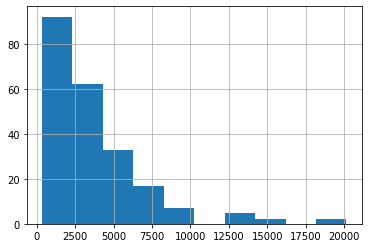

In [ ]:
from collections import defaultdict
base_json = './NLP/Entity Recognition in Resumes.json'
def pop_annot(raw_line):
    in_line = defaultdict(list, **raw_line)
    if 'annotation' in in_line:
        labels = in_line['annotation']
        for c_lab in labels:
            if len(c_lab['label'])>0:
                in_line[c_lab['label'][0]] += c_lab['points']
    return in_line
with open(base_json, 'r') as f:
    # data is jsonl and so we parse it line-by-line
    resume_data = [json.loads(f_line) for f_line in f.readlines()]
    resume_df = pd.DataFrame([pop_annot(line) for line in resume_data])
resume_df['length'] = resume_df['content'].map(len)
resume_df['length'].hist()
resume_df.sample(3)

,content,annotation,extras,highlight,length
187,Mayank Shukla\nInfosys group as a Test Analyst...,"[{'label': ['Skills'], 'points': [{'start': 23...",None,"[{'category': 'Skills', 'start': 2348, 'end': ...",3131
154,Vishwanath P\nSenior Executive (MIS & Audit) -...,"[{'label': ['College Name'], 'points': [{'star...",None,"[{'category': 'College Name', 'start': 8138, '...",8221
82,Shubham Mittal\nSystem Engineer - Infosys Limi...,"[{'label': ['Skills'], 'points': [{'start': 21...",None,"[{'category': 'Skills', 'start': 2197, 'end': ...",2231


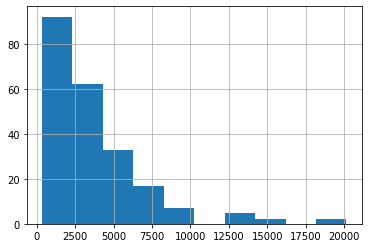

In [ ]:
def extract_higlights(raw_line):
    in_line = defaultdict(list, **raw_line)
    if 'annotation' in in_line:
        labels = in_line['annotation']
        for c_lab in labels:
            if len(c_lab['label'])>0:
                in_line['highlight'] += [dict(category = c_lab['label'][0], **cpts) for cpts in c_lab['points']]
    return in_line
resume_hl_df = pd.DataFrame([extract_higlights(line) for line in resume_data])
resume_hl_df['length'] = resume_hl_df['content'].map(len)
resume_hl_df['length'].hist()
resume_hl_df.sample(3)

In [ ]:
from string import ascii_lowercase, digits
valid_chars = ascii_lowercase+digits+'@., '
focus_col = 'highlight'
focus_df = resume_hl_df[['content', focus_col, 'length']].copy().dropna()
# clean up the text but maintain the length
focus_df['kosher_content'] = resume_df['content'].str.lower().map(lambda c_text: ''.join([c if c in valid_chars else ' ' for c in c_text]))
print(focus_col, 'with', focus_df.shape[0], 'complete results')
print('First result')
for _, c_row in focus_df.query('length<2000').sample(1, random_state = 20).iterrows():
    print(len(c_row['content']))
    for yoe in c_row[focus_col]:
        s,e = yoe['start'], yoe['end']
        print(yoe)
        print(c_row['content'][s:e+1])

highlight with 220 complete results
First result
1335
{'category': 'Skills', 'start': 1089, 'end': 1238, 'text': 'Skills: JAVA, C#, WPF, XAML, Robot Framework, Scrum, Guice, ATDD, SOA, Fixed Income, CoreNLP,\nSOLID\nprogramming, OOPs, NLP, Microservice architecture.'}
Skills: JAVA, C#, WPF, XAML, Robot Framework, Scrum, Guice, ATDD, SOA, Fixed Income, CoreNLP,
SOLID
programming, OOPs, NLP, Microservice architecture.
{'category': 'Skills', 'start': 921, 'end': 1062, 'text': 'C# (Less than 1 year), Java, OOPs, Guice, Microservice architecture, Software Development,\nXAML, ATDD, SOLID, SOA, Scrum, Robot Framework, TDD'}
C# (Less than 1 year), Java, OOPs, Guice, Microservice architecture, Software Development,
XAML, ATDD, SOLID, SOA, Scrum, Robot Framework, TDD
{'category': 'Graduation Year', 'start': 907, 'end': 910, 'text': '2016'}
2016
{'category': 'College Name', 'start': 891, 'end': 896, 'text': 'GGSIPU'}
GGSIPU
{'category': 'Degree', 'start': 858, 'end': 889, 'text': 'B.Tech(Computer

In [ ]:
def result_to_vec(in_row, focus_col):
    let_vec = in_row['kosher_content']
    attn_vec = np.zeros((len(let_vec)))
    for yoe in c_row[focus_col]:
        s,e = yoe['start'], yoe['end']
        attn_vec[s:e+1] = 1.0
    return let_vec, attn_vec

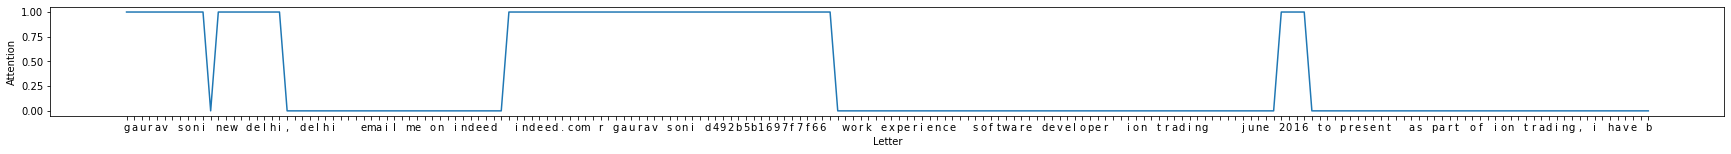

In [ ]:
x_vec, y_vec = result_to_vec(c_row, focus_col)
loc_show = np.where(y_vec)[0][0]
fig, ax1 = plt.subplots(1, 1, figsize = (30, 2))
ax1.plot(y_vec[loc_show:(loc_show+200)])
ax1.set_xlabel('Letter')
ax1.set_ylabel('Attention')
ax1.set_xticks(range(200))
ax1.set_xticklabels(x_vec[loc_show:(loc_show+200)]);

In [ ]:


from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(focus_df, test_size = 0.2)
print(train_df.shape, valid_df.shape)



(176, 4) (44, 4)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
feat_cv = CountVectorizer(analyzer='char') # too complicated
from sklearn.preprocessing import LabelEncoder

In [ ]:
let_enc = LabelEncoder()
let_enc.fit_transform(list(valid_chars))
print(let_enc.classes_.shape)

(40,)


In [ ]:
def result_to_fvec(in_row, focus_col):
    let_vec = in_row['kosher_content']
    attn_vec = np.zeros((len(let_vec)))
    flet_vec = let_enc.transform(list(let_vec))
    for yoe in c_row[focus_col]:
        s,e = yoe['start'], yoe['end']
        attn_vec[s:e+1] = 1.0
    return let_vec, flet_vec, attn_vec

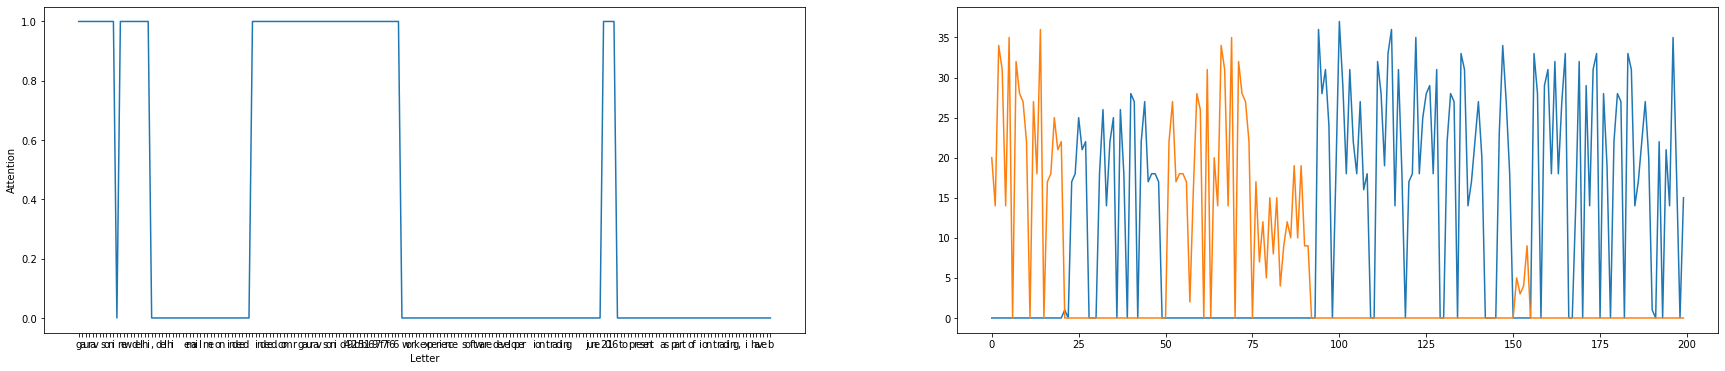

In [ ]:
x_vec, fx_vec, y_vec = result_to_fvec(c_row, focus_col)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30, 6))
ax1.plot(y_vec[:200])
ax1.set_xlabel('Letter')
ax1.set_ylabel('Attention')
ax1.set_xticks(range(200))
ax1.set_xticklabels(x_vec[:200]);
for t_val in [0, 1]:
    ax2.plot((fx_vec*(y_vec==t_val))[:200], '-', label = 'Attention {}'.format(t_val))

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from scipy.ndimage import convolve1d 
def package_df(in_df, minichunk_size = None, minichunk_upsampler = 10):
    train_x, train_y = [], []
    for _, c_row in in_df.iterrows():
        _, fx_vec, y_vec = result_to_fvec(c_row, focus_col)
        smooth_y_vec = convolve1d(y_vec.astype(np.float32), np.ones((10,))/5)
        if minichunk_size is not None:
            sample_count = fx_vec.shape[0]//minichunk_size*minichunk_upsampler//2
            # normal samples
            for s_idx in np.random.choice(range(fx_vec.shape[0]-minichunk_size), sample_count):
                train_x += [fx_vec[s_idx:(s_idx+minichunk_size)]]
                train_y += [np.expand_dims(smooth_y_vec[s_idx:(s_idx+minichunk_size)], -1)]
            # positive samples
            pos_sample_vec = convolve1d(y_vec.astype(np.float32), np.ones((32,)))
            pos_idx = np.where(pos_sample_vec>0)[0]
            if len(pos_idx)>0:
                for s_idx in np.random.choice(pos_idx, sample_count):
                    train_x += [fx_vec[s_idx:(s_idx+minichunk_size)]]
                    train_y += [np.expand_dims(smooth_y_vec[s_idx:(s_idx+minichunk_size)], -1)]
        else:
            train_x += [fx_vec]
            train_y += [np.expand_dims(y_vec, -1)]
    return pad_sequences(train_x), pad_sequences(train_y)
train_x, train_y = package_df(train_df.query('length>256'), minichunk_size = 256)
print(train_x.shape, train_y.shape)
valid_x, valid_y = package_df(valid_df)
print(valid_x.shape, valid_y.shape)

(24920, 256) (24920, 256, 1)
(44, 12645) (44, 12645, 1)


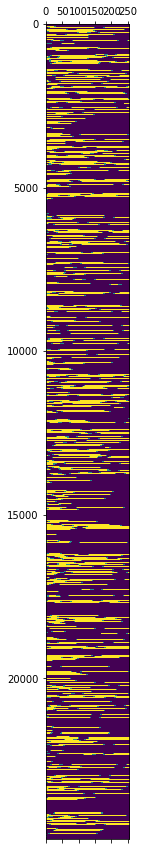

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (8, 15))
ax1.matshow(train_y[:, :, 0])
ax1.set_aspect(.10)

In [ ]:
from keras.layers import Embedding, Bidirectional, LSTM, Conv1D, SpatialDropout1D, ZeroPadding1D
from keras.layers import CuDNNLSTM as LSTM  
from keras.models import Sequential                       
simple_model = Sequential()
simple_model.add(Embedding(input_dim=let_enc.classes_.shape[0]+1, 
                           output_dim=16))
simple_model.add(SpatialDropout1D(0.25, name='DropLetters'))
simple_model.add(Conv1D(32, kernel_size=(5,), activation='relu', padding='valid', name = 'BigramCreation'))
simple_model.add(Conv1D(32, kernel_size=(3,), activation='relu', padding='valid', name = 'TrigramCreation'))
simple_model.add(Conv1D(64, kernel_size=(3,), activation='relu', padding='valid'))
simple_model.add(SpatialDropout1D(0.5, name='DropGrams'))
simple_model.add(Conv1D(128, kernel_size=(3,), dilation_rate = 2, activation='relu', padding='same'))
simple_model.add(Conv1D(128, kernel_size=(3,), dilation_rate = 4, activation='relu', padding='same'))
simple_model.add(Conv1D(128, kernel_size=(3,), dilation_rate = 6, activation='relu', padding='same'))
#simple_model.add(Bidirectional(LSTM(64, return_sequences=True)))
#simple_model.add(SpatialDropout1D(0.25))
#simple_model.add(Bidirectional(LSTM(32, return_sequences=True)))
simple_model.add(Conv1D(1, kernel_size=(1,), activation='sigmoid'))
simple_model.add(ZeroPadding1D((4, 4), name = 'CorrectForConv1Ds'))
simple_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          656       
_________________________________________________________________
DropLetters (SpatialDropout1 (None, None, 16)          0         
_________________________________________________________________
BigramCreation (Conv1D)      (None, None, 32)          2592      
_________________________________________________________________
TrigramCreation (Conv1D)     (None, None, 32)          3104      
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          6208      
_________________________________________________________________
DropGrams (SpatialDropout1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         2

In [ ]:


simple_model.predict(train_x[0:1]).shape



(1, 256, 1)

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

def dice_coef_1d(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    """combine DICE and BCE"""
    return 0.5*binary_crossentropy(in_gt, in_pred) - dice_coef_1d(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
simple_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef_1d, 
                                                                                 'binary_crossentropy', 
                                                                                 'binary_accuracy', 
                                                                                 true_positive_rate])

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('resume_attention.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
batch_size = 512
results = simple_model.fit(
    train_x, train_y,
    epochs = 20, 
    batch_size = 256,
    validation_data = (valid_x, valid_y),
    shuffle = True,
    callbacks=callbacks)

Epoch 1/20


TypeError: ignored